### Time series

#### Imports

In [260]:
import yfinance as yf
import shap
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
# Bidirectional , 
from tensorflow.keras.layers import Dense, LSTM,GRU, Reshape# captum (biblioteca de interpretação pytorch)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
tf.compat.v1.disable_v2_behavior() # caracteristica necessaria para o uso shap


#### Loader

In [261]:
class DataLoader(BaseEstimator, TransformerMixin):
  def __init__(self, dataset: pd.DataFrame, lag):
    super()
    self.dataset = dataset
    self.dataset["Date"] = self.dataset["Date"].apply(lambda date: pd.to_datetime(date, format="ISO8601"))#,inplace=True

    self.lag = lag
    self.scaler = MinMaxScaler()

  def get_indexs_split(self, percent = .8):
    train_size = int(len(self.dataset) * percent)
    train_idx, test_idx = self.dataset.iloc[self.lag:train_size,:], self.dataset.iloc[train_size:,:]
    return train_idx.index, test_idx.index

  def fit(self, indexs, y=None):

    x_train = self.dataset[["Close"]].iloc[indexs]
    self.scaler.fit(x_train, [])
    return self
  
  def get_values(self):
     return self.values if self.values is not None else None
  
  def get_target(self):
     return self.target if self.target is not None else None
  
  def transform(self, indexs, y=None):
    if (indexs[0] - self.lag > 0):
       idxs = self.dataset.index[indexs[0] - (self.lag + 1): indexs[-1]]
    else:
       idxs = indexs
    
    X = self.dataset.loc[idxs]
    X.set_index(idxs)
    # landslides['date_parsed'] = pd.to_datetime(landslides['date'], format="%m/%d/%y")


    
    lagged_X = X[['Close']].copy()
    
    for lag in range(1, self.lag + 1):
        lagged_X[f'lag{lag}'] = lagged_X['Close'].shift(lag)
    lagged_X = lagged_X.apply(lambda x: (x-self.scaler.min_[0])/(self.scaler.data_max_[0] - self.scaler.min_[0]))
    # lagged_X = lagged_X.apply(lambda x: self.scaler.transform(x.reshape((1,-1))))
    
    lagged_X.dropna(inplace=True)
    self.values = lagged_X.drop(columns=['Close']).copy()
    self.target = lagged_X[['Close']].copy()

    return (np.array(lagged_X.drop(columns=['Close']).to_numpy(dtype=np.float32)), 
            np.array(lagged_X[['Close']].to_numpy(dtype=np.float32)))
  
  def inverse_transform(self, X, y=None):
    # x_inverse = X.apply(lambda x: x*(self.scaler.data_max_[0] - self.scaler.min_[0]) + self.scaler.min_[0])
    x_inverse = np.apply_along_axis(lambda x: x*(self.scaler.data_max_[0] - self.scaler.min_[0]) + self.scaler.min_[0], 0, X)


    # x_inverse = X.apply(lambda x: self.scaler.inverse_transform(x), 0)
    #  self.scaler.inverse_transform(X)
    return x_inverse
    
  def fit_transform(self, X, y = None):
      return self.fit(X, y).transform(X, y)

#### Carrega os dados

In [262]:
data = pd.read_csv("../data.csv")
data = data[["Date", "Close"]]

#### Normaliza

In [263]:
data_loader = DataLoader(data, lag=6)
train_indexs, test_indexs = data_loader.get_indexs_split()
x_train, y_train = data_loader.fit_transform(train_indexs)

In [264]:
x_train.shape, y_train.shape

((3311, 6), (3311, 1))

In [265]:
type(np.array(x_train))

numpy.ndarray

In [266]:
print(type(x_train))
# ndarray

<class 'numpy.ndarray'>


In [267]:
x_train[0], y_train[0]

(array([0.35753304, 0.3566044 , 0.35907242, 0.3605449 , 0.35698923,
        0.35419494], dtype=float32),
 array([0.35538292], dtype=float32))

In [268]:
x_test, y_test = data_loader.transform(test_indexs)

In [269]:
x_test.shape, y_test.shape

((831, 6), (831, 1))

In [270]:
data_loader.inverse_transform(y_train[:10])

array([[42478.   ],
       [43428.   ],
       [43553.   ],
       [44177.   ],
       [44687.   ],
       [44412.   ],
       [43573.   ],
       [44044.   ],
       [44641.996],
       [44815.   ]], dtype=float32)

#### Modelos

In [271]:
tf.random.set_seed(22)

In [272]:
# Define the GRU model
def GRU_Model(output_window, look_back):
    model = Sequential([
            tf.keras.layers.Reshape((1, -1)),
            tf.keras.layers.GRU(128, return_sequences=False, input_shape=(1, look_back)),
            tf.keras.layers.Dense(output_window)
        ])
    # optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    # model.compile(optimizer=optimizer , loss='mean_squared_error')
    model.compile(optimizer="adam" , loss='mean_squared_error')
    return model

# Define the LSTM model
def LSTM_Model(output_window, look_back):
    model = Sequential([
        tf.keras.layers.Reshape((1, -1)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128, activation='relu', input_shape=(1, look_back), return_sequences=True)),
        tf.keras.layers.Dense(output_window)
    ])
    model.compile(optimizer="adam" , loss='mean_squared_error')

    return model

# Define the baseline model
def baseline_model(output_window, y_train):
    last_known_value = y_train[-1]
    return np.full((len(y_test), output_window), last_known_value)

# Train and evaluate the models
output_window = 1
gru_model = GRU_Model(output_window, data_loader.lag)
lstm_model = LSTM_Model(output_window, data_loader.lag)

#### Treinamentos

In [273]:
print("gru_model")
print("*"*50)
gru_model.fit(x_train, y_train, epochs=1, batch_size=64)
print("lstm_model")
print("*"*50)
lstm_model.fit(x_train, y_train, epochs=1, batch_size=64)

gru_predictions = gru_model.predict(x_test)
lstm_predictions = lstm_model.predict(x_test)
baseline_predictions = baseline_model(output_window, y_train)


gru_model
**************************************************


Train on 3311 samples
3311/3311 [==============================] - 3s 770us/sample - loss: 0.0375
lstm_model
**************************************************
Train on 3311 samples
3311/3311 [==============================] - 3s 1ms/sample - loss: 0.0932


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [274]:
# Inverse transform the predictions
gru_predictions_real = data_loader.scaler.inverse_transform(gru_predictions.reshape(-1,1))
lstm_predictions_real = data_loader.scaler.inverse_transform(lstm_predictions.reshape(-1,1))
baseline_predictions_real = data_loader.scaler.inverse_transform(baseline_predictions.reshape(-1,1))

In [275]:
x_train.shape

(3311, 6)

In [276]:
lstm_predictions.shape

(831, 1, 1)

### Explicabilidade

#### gru_model

In [277]:
data_loader.dataset

,Date,Close
0,2007-01-02,45383.0
1,2007-01-03,44445.0
2,2007-01-04,44020.0
3,2007-01-05,42245.0
4,2007-01-08,42830.0
...,...,...
4149,2023-10-09,115156.0
4150,2023-10-10,116737.0
4151,2023-10-11,117051.0
4152,2023-10-13,115754.0


In [278]:
# landslides['date_parsed'] = pd.to_datetime(landslides['date'], format="%m/%d/%y")

# pd.to_datetime(landslides['date'], format="%m/%d/%y")
data_loader.dataset["Date"].apply(lambda date: pd.to_datetime(date, format="ISO8601"))#,inplace=True

0      2007-01-02
1      2007-01-03
2      2007-01-04
3      2007-01-05
4      2007-01-08
          ...    
4149   2023-10-09
4150   2023-10-10
4151   2023-10-11
4152   2023-10-13
4153   2023-10-16
Name: Date, Length: 4154, dtype: datetime64[ns]

In [279]:
data_loader.get_values()

,lag1,lag2,lag3,lag4,lag5,lag6
3322,0.776346,0.792166,0.809409,0.816922,0.791756,0.784997
3323,0.772840,0.776346,0.792166,0.809409,0.816922,0.791756
3324,0.782503,0.772840,0.776346,0.792166,0.809409,0.816922
3325,0.799370,0.782503,0.772840,0.776346,0.792166,0.809409
3326,0.804205,0.799370,0.782503,0.772840,0.776346,0.792166
...,...,...,...,...,...,...
4148,0.947761,0.950464,0.948891,0.962595,0.975211,0.968233
4149,0.955174,0.947761,0.950464,0.948891,0.962595,0.975211
4150,0.963423,0.955174,0.947761,0.950464,0.948891,0.962595
4151,0.976650,0.963423,0.955174,0.947761,0.950464,0.948891


In [280]:

# tf.compat.v2.enable_v2_behavior()
# tf.compat.v1.disable_eager_execution()
sample_train = x_train[:100].copy()
gru_explainer = shap.DeepExplainer(gru_model, data=sample_train)  # Substitua 10 pelo número desejado de exemplos para a baseline

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


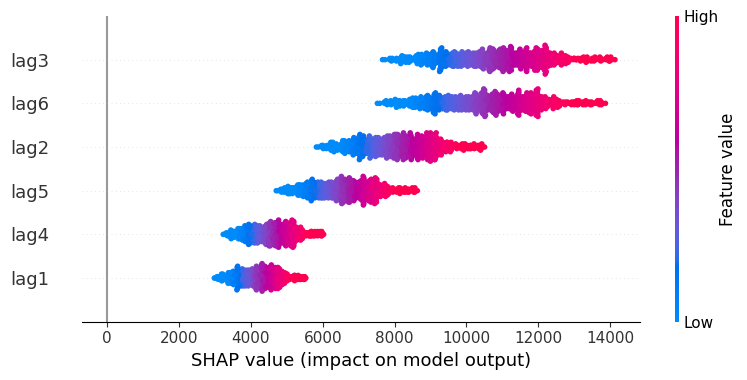

In [281]:
# Calcular os valores SHAP
sample = x_test.copy()
shap_values = gru_explainer.shap_values(sample)

# Visualizar as contribuições
shap.summary_plot(
  data_loader.inverse_transform(shap_values[0]), 
  data_loader.inverse_transform(sample), 
  feature_names=data_loader.get_values().columns
)

In [282]:
shap.initjs()
shap.force_plot(
  data_loader.inverse_transform(gru_explainer.expected_value)[0], 
  data_loader.inverse_transform(shap_values[0][0]), 
  feature_names=data_loader.get_values().columns
    # gru_explainer.expected_value[0], shap_values[0][0], feature_names=data.columns
)

#### `dependence_plot` não é tão interessante

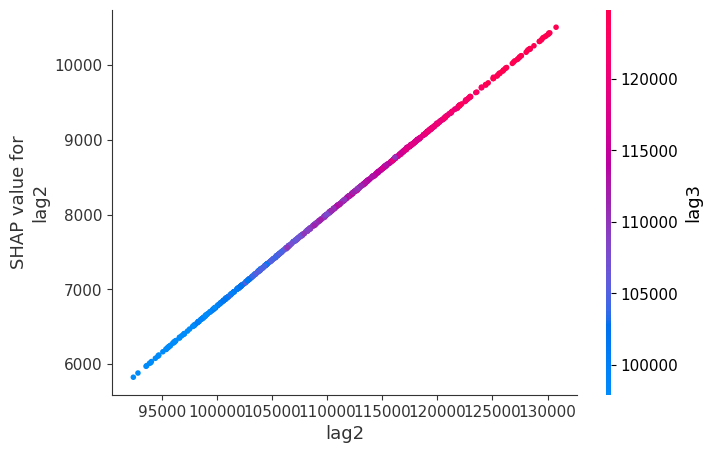

In [283]:
shap.dependence_plot(
  1,
  data_loader.inverse_transform(shap_values[0]), 
  data_loader.inverse_transform(sample), 
  feature_names=data_loader.get_values().columns
  # 1, shap_values[0], sample, feature_names=data.columns 
)


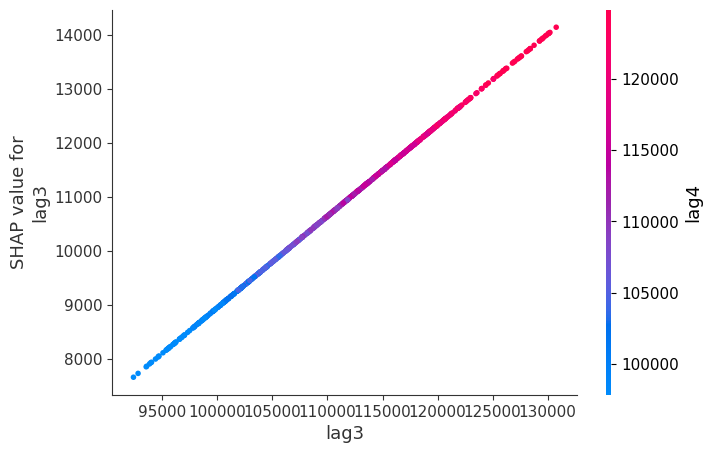

In [284]:
shap.dependence_plot(
  2,
  data_loader.inverse_transform(shap_values[0]), 
  data_loader.inverse_transform(sample), 
  feature_names=data_loader.get_values().columns
  # 2, shap_values[0], sample, feature_names=data.columns 
)


#### waterfall

### Lime

In [285]:
from lime.lime_tabular import LimeTabularExplainer

# Criando um explainer do Lime
explainer = LimeTabularExplainer(x_train,
                                 mode="regression", 
                                 feature_names=data_loader.get_values().columns, 
                                 class_names=['ibv'], 
                                 categorical_features=[0],
                                 discretize_continuous=True)

784


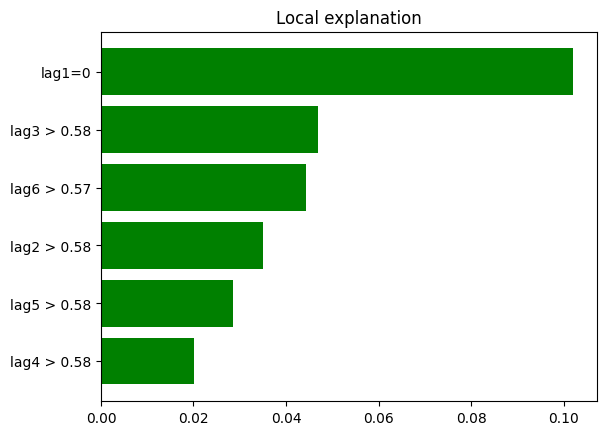

In [286]:
sample_idx = np.random.choice(range(len(test_indexs)), size=(1,))[0]
print(sample_idx)
X_sample = x_test[sample_idx]

# Explicação do modelo usando o explainer do Lime
explanation = explainer.explain_instance(X_sample, 
                                         gru_model.predict, 
                                         num_features=(data_loader.lag))

# Visualizando a explicação
fig = explanation.as_pyplot_figure()
plt.show()

#### Plots

In [287]:
# y_test.shape, gru_predictions[0]
y_train_real = data_loader.inverse_transform(y_train)
y_test_real = data_loader.inverse_transform(y_test)

In [288]:
test_indexs[1:].shape, y_test.shape

((830,), (831, 1))

In [289]:
y_test.shape

(831, 1)

In [290]:
# gru_predictions.reshape(-1, 1).shape
lstm_predictions.reshape(-1, 1).shape

(831, 1)

In [291]:
date_train = data_loader.dataset["Date"].iloc[train_indexs]
date_test =  data_loader.dataset["Date"].iloc[test_indexs]

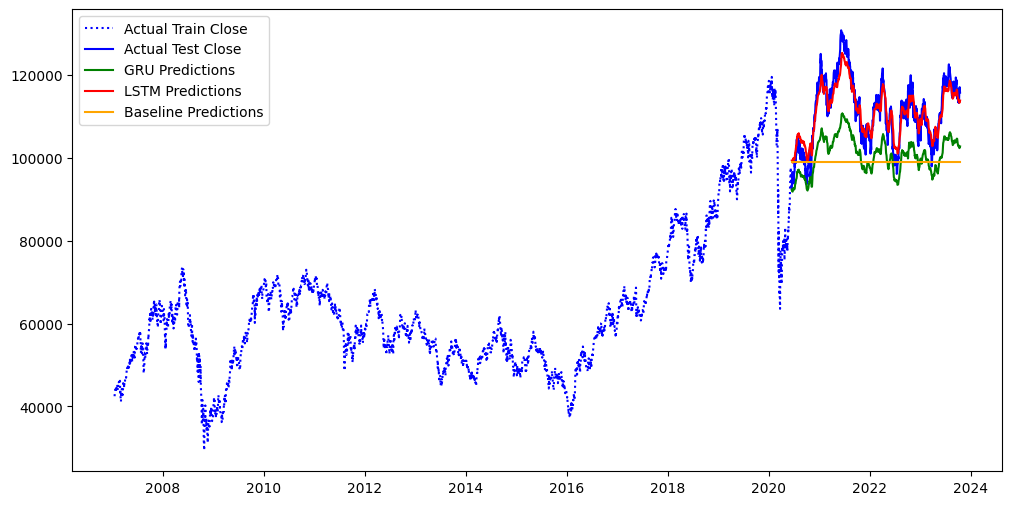

In [292]:
plt.figure(figsize=(12, 6))
plt.plot(date_train[data_loader.lag:], y_train_real, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(date_test, y_test_real, label='Actual Test Close', color='blue')
plt.plot(date_test, gru_predictions_real, label='GRU Predictions', color='green')
plt.plot(date_test, lstm_predictions_real.reshape(-1, 1), label='LSTM Predictions', color='red')
plt.plot(date_test, baseline_predictions_real, label='Baseline Predictions', color='orange')
plt.legend()
plt.show()

#### Metricas

In [293]:
gru_mse = mean_squared_error(y_test_real, gru_predictions_real)
lstm_mse = mean_squared_error(y_test_real, lstm_predictions_real)
baseline_mse = mean_squared_error(y_test_real, baseline_predictions_real)

gru_mape = mean_absolute_percentage_error(y_test_real, gru_predictions_real)
lstm_mape = mean_absolute_percentage_error(y_test_real, lstm_predictions_real)
baseline_mape = mean_absolute_percentage_error(y_test_real, baseline_predictions_real)

gru_mae = mean_absolute_error(y_test_real, gru_predictions_real)
lstm_mae = mean_absolute_error(y_test_real, lstm_predictions_real)
baseline_mae = mean_absolute_error(y_test_real, baseline_predictions_real)

# Compare the models using Mean Squared Error

print(f"\t\tGRU \t\tLSTM \t\tBaseline: ")
print("MSE: \t{:.2f}\t{:.2f}\t{:.2f}".format(gru_mse,lstm_mse,baseline_mse))
print("RMSE: \t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(np.sqrt(gru_mse), np.sqrt(lstm_mse), np.sqrt(baseline_mse)))
print("MAE: \t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(gru_mae,lstm_mae,baseline_mae))
print("MAPE: \t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(gru_mape,lstm_mape,baseline_mape))


		GRU 		LSTM 		Baseline: 
MSE: 	125750200.00	8188144.50	211833056.00
RMSE: 	11213.84		2861.49		14554.49
MAE: 	10398.45		2370.78		12411.07
MAPE: 	0.09		0.02		0.11
